This adapts the Jupyter Notebook from the Towards Data Science article on [Topic Modeling in Python: Latent Dirichlet ALlocation (LDA)](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

[Juypter Notebook can be found here.](https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Introduction%20to%20Topic%20Modeling.ipynb)

### Loading data
Loading an example site-wide classification results data.

In [1]:
import pandas as pd
import os
from wordcloud import WordCloud
# from utils import config

input_dir = os.path.join(os.getcwd())
input_path = os.path.join(input_dir, 'ClassificationResults_SV_4IL1lhWMo7LhrjD_20191219-074327.xlsx')

# Read data into papers
papers = pd.read_excel(input_path)

Let's explore how the `Comments Concatenated` column looks like:

In [2]:
papers['Comments Concatenated'].head()

0                                         nannannannan
1    need locate some unclaimed money that owe alab...
2    need change address and be able through the un...
3                                         nannannannan
4                                         nannannannan
Name: Comments Concatenated, dtype: object

Let's also see how `Normalized Comments` column looks like, they should be fairly similar and can use this as the feature.

In [3]:
papers['Normalized Comments'].head()

0                                         nannannannan
1    need locate some unclaimed money that owe alab...
2    need change address and be able through the un...
3                                         nannannannan
4                                         nannannannan
Name: Normalized Comments, dtype: object

#### Data Cleaning
The data looks like it has some `nan`.  The data should have been cleaned before it gets to this point, but want to do a little bit more to get rid of those that were not caught before.

In [4]:
# Load the regular expression library
import re

papers['Comments_Concat_processed'] = papers['Normalized Comments'].astype(str).map(lambda x: re.sub('nan', '', x))
papers['Comments_Concat_processed'].head()

0                                                     
1    need locate some unclaimed money that owe alab...
2    need change address and be able through the un...
3                                                     
4                                                     
Name: Comments_Concat_processed, dtype: object

#### Exploratory Analysis

Making a word cloud to visualize the most common words.

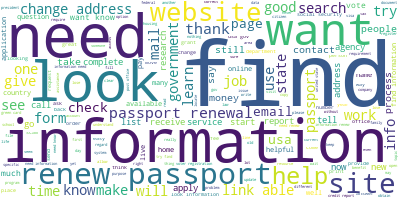

In [5]:
# # Join the different processed titles together.
long_string = ','.join(list(papers['Comments_Concat_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

#### Prepare text for LDA analysis
Transform the textual data in a format that will serve as an input for training LDA model.  Start by converting the documents into a simple vector representation (Bag of Words BOW).  Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.

THen we will plot the ten most frequent words based on the outcome of this operation.

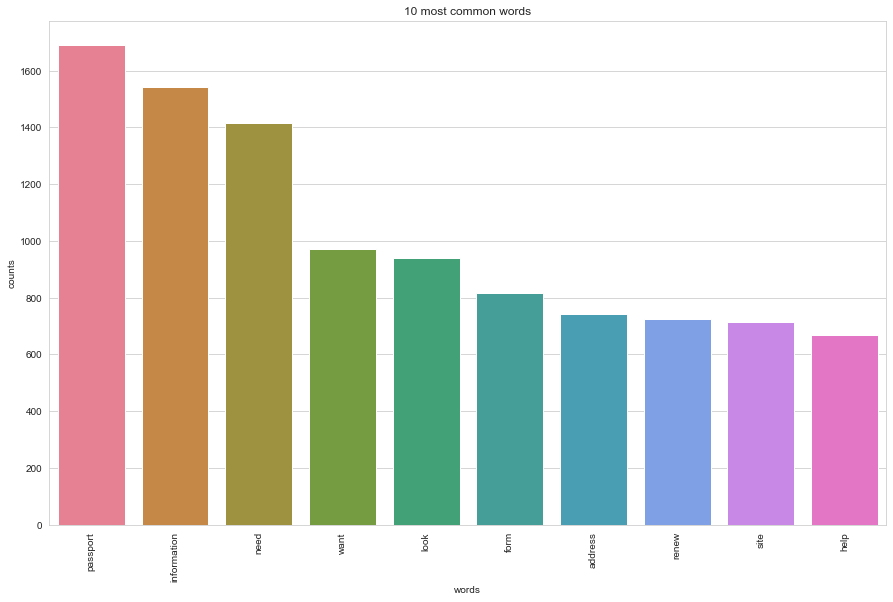

In [6]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(papers['Comments_Concat_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

#### LDA model training
Tweaking the number of topic parameters

In [7]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
look information site government website job search just gov question

Topic #1:
address change want report information mail know good site need

Topic #2:
help money want people work like usa grant country year

Topic #3:
agency help research available obtain purpose law official visit information

Topic #4:
passport need form renew renewal information easy application complete online


#### Analyzing our LDA model
Using pyLDAvis to visualize the topics for interpretability:
- Better understanding and interpreting individual topics
- Better understanding the relationships between the topics

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic. For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [8]:
%%time

from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
    LDAvis_prepared

CPU times: user 1.12 s, sys: 110 ms, total: 1.23 s
Wall time: 5.35 s


/Users/amyymok/.local/share/virtualenvs/10x-MLaaS-page-survey-CcEhlLsz/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [9]:
pyLDAvis.display(LDAvis_prepared)